# MSA 2024 Phase 2 - Part 2

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load and split preprocessed data

In [308]:
# read data
sales = pd.read_csv('store_sales.csv', encoding='latin1') 
# went through process of elimination to find the encoding that worked with reading the file through pandas
sales[:5]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [309]:
# next, i'll be removing the unnessecary columns to our data
# this is since I want perform machine learning training on the dataset, and create a regression model
# Aka, i want a model that predicts the sales of our data, and also forecast the next 4 weeks of sales

# Row ID, Order ID, Customer ID, Customer Name, Product ID > Redundant unique information, that has no effect on sales
# Country, Category > Only 1 data point in the entire column
# City, Region, State > Remove redundant location details, Postal Code provides the needed specification of location
# Ship Mode, Segment, Sub-Category, Product Name > Regression models are not able to handle strings, unless they have been individually one-hot encoded
sales = sales.drop(['Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Country', 'City', 'Region', 'State', 'Product ID', 'Category', 'Ship Mode', 'Segment', 'Sub-Category', 'Product Name'], axis=1)
sales

,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
0,11/8/2016,11/11/2016,42420,261.9600,2,0.00,41.9136
1,11/8/2016,11/11/2016,42420,731.9400,3,0.00,219.5820
2,10/11/2015,10/18/2015,33311,957.5775,5,0.45,-383.0310
3,6/9/2014,6/14/2014,90032,48.8600,7,0.00,14.1694
4,6/9/2014,6/14/2014,90032,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...
2116,3/19/2015,3/22/2015,77041,383.4656,4,0.32,-67.6704
2117,12/5/2016,12/10/2016,19711,13.4000,1,0.00,6.4320
2118,9/6/2015,9/9/2015,70506,85.9800,1,0.00,22.3548
2119,1/21/2014,1/23/2014,33180,25.2480,3,0.20,4.1028


In [310]:
# Convert date columns from object type, into date type for the machine learning algorithm to use in predicting sales
sales['Order Date'] = pd.to_datetime(sales['Order Date'], format='%m/%d/%Y') # format is Month, Day, Year as that is the order of the original column
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'], format='%m/%d/%Y')

sales.info() # checking if Dtype for both data columns have changed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order Date   2121 non-null   datetime64[ns]
 1   Ship Date    2121 non-null   datetime64[ns]
 2   Postal Code  2121 non-null   int64         
 3   Sales        2121 non-null   float64       
 4   Quantity     2121 non-null   int64         
 5   Discount     2121 non-null   float64       
 6   Profit       2121 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 116.1 KB


In [311]:
# After sorting date columns, I also want to extract away a 4 week period of the dataset, so it can be used to see how well the model can predict
# upcoming new data
sales = sales.sort_values(by='Order Date') # sort our data in order by date
sales = sales.reset_index(drop=True) # resetting index to the order of dates

sales # our forecast month, will be 2017/12

,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
0,2014-01-06,2014-01-10,42420,2573.820,9,0.0,746.4078
1,2014-01-07,2014-01-12,77340,76.728,3,0.6,-53.7096
2,2014-01-10,2014-01-15,22153,51.940,1,0.0,21.2954
3,2014-01-11,2014-01-14,19901,9.940,2,0.0,3.0814
4,2014-01-13,2014-01-16,29464,545.940,6,0.0,87.3504
...,...,...,...,...,...,...,...
2116,2017-12-29,2018-01-01,40214,258.750,3,0.0,77.6250
2117,2017-12-29,2018-01-01,40214,1207.840,8,0.0,314.0384
2118,2017-12-29,2018-01-05,92804,101.120,8,0.0,37.4144
2119,2017-12-29,2018-01-01,40214,300.980,1,0.0,87.2842


In [312]:
# for our 'forecast', we first have to find the year '2017' and month '12' from the Order Date column
forecast = sales[(sales['Order Date'].dt.year == 2017) & (sales['Order Date'].dt.month == 12)]
forecast

,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
2015,2017-12-01,2017-12-06,98105,70.680,12,0.0,31.0992
2016,2017-12-01,2017-12-08,98105,141.960,2,0.0,41.1684
2017,2017-12-01,2017-12-05,19140,398.972,2,0.3,-28.4980
2018,2017-12-01,2017-12-04,19120,79.120,5,0.2,13.8460
2019,2017-12-01,2017-12-05,75051,317.058,3,0.3,-18.1176
...,...,...,...,...,...,...,...
2116,2017-12-29,2018-01-01,40214,258.750,3,0.0,77.6250
2117,2017-12-29,2018-01-01,40214,1207.840,8,0.0,314.0384
2118,2017-12-29,2018-01-05,92804,101.120,8,0.0,37.4144
2119,2017-12-29,2018-01-01,40214,300.980,1,0.0,87.2842


In [313]:
# now to remove these columns from the original dataframe
sales = sales[~((sales['Order Date'].dt.year == 2017) & (sales['Order Date'].dt.month == 12))] # practically the same as the above, but we used '~'
# '~' Operates as a NOT operator, like the AND '&' operator we used, only selecting the datetime that is not year 2017, and month 12
sales

,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
0,2014-01-06,2014-01-10,42420,2573.820,9,0.0,746.4078
1,2014-01-07,2014-01-12,77340,76.728,3,0.6,-53.7096
2,2014-01-10,2014-01-15,22153,51.940,1,0.0,21.2954
3,2014-01-11,2014-01-14,19901,9.940,2,0.0,3.0814
4,2014-01-13,2014-01-16,29464,545.940,6,0.0,87.3504
...,...,...,...,...,...,...,...
2010,2017-11-29,2017-12-03,37421,101.520,5,0.2,19.0350
2011,2017-11-30,2017-12-03,94109,25.830,3,0.0,9.5571
2012,2017-11-30,2017-12-07,27217,1781.682,7,0.4,-653.2834
2013,2017-11-30,2017-12-02,10024,1242.900,5,0.1,262.3900


In [314]:
# From the previous part of the project, removing outliers in the profit column, if it is either above 1000, or below -1000 in profit
sales = sales[(sales['Profit'] <= 1000) & (sales['Profit'] >= -1000)]

sales.count() # checking if column numbers have changed, indicating that we've removed the outliers

Order Date     2011
Ship Date      2011
Postal Code    2011
Sales          2011
Quantity       2011
Discount       2011
Profit         2011
dtype: int64

In [315]:
# We should also check whether there are any missing values in the dataset as well
sales.isnull().sum()

Order Date     0
Ship Date      0
Postal Code    0
Sales          0
Quantity       0
Discount       0
Profit         0
dtype: int64

In [316]:
# With the cleaning and isolating the important columns in the dataset, lets create a train test split on the data
np.random.seed(35) # set a constant seed, so all our other tweaks to the data, will be performed on random data, that has been arranged the same
from sklearn.model_selection import train_test_split # import the sklearn train test split programme

# split the data into x and y, one is the data without the target variable 'Sales', and then vice versa for the other
x = sales.drop('Sales', axis=1)
y = sales['Sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) # test size of dataset, is 20% of the total data
# leaving the other 80% of the dataset, used for training only

In [317]:
x_train.count()

Order Date     1608
Ship Date      1608
Postal Code    1608
Quantity       1608
Discount       1608
Profit         1608
dtype: int64

In [318]:
x_test.count() # double checking on the outputted train test split, to see if the data has split correctly

Order Date     403
Ship Date      403
Postal Code    403
Quantity       403
Discount       403
Profit         403
dtype: int64

In [319]:
403/2011 # confirms out test set, has 20% of the dataset

0.20039781203381402

## 2. Choose an algorithm

There is this neat webpage from scikit learn, called 'Choosing the right estimator' https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html

I will be following the algorithm cheat-sheet, to find the algorithm I'll be using on this dataset:

YES to `>50 samples`

NO to `predicitng categories`

YES to `predicting quantities`

YES to `<100k samples`

UNSURE to `few important features` < There's a possibility that all the columns are important, or only 2 are important
#### Regardless of my indecisiveness, I want to keep my options open and try one algorithm on the YES side, and one on the NO side.

#### This gives us either Lasso or ElasticNet, and RidgeRegression or SVR
 I will be choosing Lasso, and RidgeRegression

### Lasso:
Known as `Least Absolute Shrinkage` and `Selection Operator`. 

`Least Absolute` means the usage of L1 regularization technique, where we look at the sum of the absolute values (difference) of the coefficients (relationship between the predicting variables, vs the target variable). `Shrinkage` means shrinking the unimportant features towards zero, in terms of the penalty of L1, in order to reduce complexity of the model, and prevent overfitting.

`Selection` means selecting only the most significant predictors to the target variable, and excluding less important features in the model, in order to unhance model interpretability and performance. `Operator` means applying the mathematical operations to L1 penalties to the coefficients during model training.

#### TLDR: Lasso model both shrinks, by reducing the ability to overfit, and selects, by simplifying the model and excluding irrelevant features

### RidgeRegression

Is a type of linear regression, incorporating both `L2 Regularization` and adding the penalty term to the `Ordinary Least Squares` loss function.

`L2 Regularization` means squaring the coefficients (relationship between the predicting variable, vs the target variable) as its penalty term. It penalizes larger coefficients more heavily due to squaring, but is the opposite with smaller coefficients, in order to prevent model from relying too heavily on any singular feature.

`Ordinary Least Squares` means estimating the coefficients using linear regression model. The goal is minimizing the sum of the squared differences between target, and predicted target. It finds the best fitting line that minimizes squared errors.

#### TLDR: Ridge heavily penalizes large variations between predicted and target variables, and the best fitting line for the coefficients

## 3. Train and test a model

## Using Lasso

In [320]:
# import our first model 'Lasso'
from sklearn.linear_model import Lasso

# I ran this code and reached an error. Turns out, you can't use datetime objects in the model. Thus I will be converting them into separated variables
# Year, Month, and Day are split into their own columns
x_train['Order_Year'] = x_train['Order Date'].dt.year
x_train['Order_Month'] = x_train['Order Date'].dt.month
x_train['Order_Day'] = x_train['Order Date'].dt.day

x_test['Order_Year'] = x_test['Order Date'].dt.year
x_test['Order_Month'] = x_test['Order Date'].dt.month
x_test['Order_Day'] = x_test['Order Date'].dt.day

x_train['Ship_Year'] = x_train['Ship Date'].dt.year
x_train['Ship_Month'] = x_train['Ship Date'].dt.month
x_train['Ship_Day'] = x_train['Ship Date'].dt.day

x_test['Ship_Year'] = x_test['Ship Date'].dt.year
x_test['Ship_Month'] = x_test['Ship Date'].dt.month
x_test['Ship_Day'] = x_test['Ship Date'].dt.day

# Then drop the original date columns
x_train = x_train.drop(columns = ['Order Date', 'Ship Date'])
x_test = x_test.drop(columns = ['Order Date', 'Ship Date'])

model = Lasso() # create variable name for Lasso, just so its easier for us to use in our code
model.fit(x_train, y_train) # fitting our model using our training sets
model.score(x_test, y_test) # then scoring the model, by having it to predict from x_test, then evaluating it with y_test

0.27731940615346007

In [321]:
# Not a very accurate model, with getting just about 27% correct in sales
# Lets perform some evaluation metrics to better gauge on the model's accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # import our evaluation metrics

y_pred = model.predict(x_test) # create a variable, that holds the target variable predictions, made by the model from the test dataset

r2_score(y_test, y_pred)

0.27731940615346007

In [322]:
mean_absolute_error(y_test, y_pred)

283.16227785018475

In [323]:
mean_squared_error(y_test, y_pred)

188463.68809256528

In [324]:
# Lets do some adjustments to the model, and see how well it performs
# I will be using StandardScaler:
# It 'Standardizes' by ensuring all data features contribute equally to the model
# It 'Scales' by making the variables based on its standard deviation, and setting its mean to 0, allowing very constant value scaling with all of them

from sklearn.preprocessing import StandardScaler # importing the scaling method

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Lets try to perform our new scaling method to the model
model.fit(x_train_scaled, y_train)
model.score(x_test_scaled, y_test)

0.27436670940616115

In [325]:
# Pretty disappointed with the result, no change. Lets try another adjustment tool - GridSearchCV
# What it does is I give it a dictionary of random parameters, and GridSearch does an exhaustive search over all the specified parameters
from sklearn.model_selection import GridSearchCV

# Lasso model only has one important parameter that we can tweak, making it useful for GridSearch
param_grid = {
    'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    # alpha controls the regularization strength. Lower = overfitting, Higher = underfitting
}

grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=5, # cv is the number of splits in the data
                          n_jobs=-1) # n_jobs is usage on cpu, -1 means using all cpu power (typically for complex models)

grid_search.fit(x_train, y_train)
grid_search.score(x_test, y_test)

0.27731940615346007

## Using RidgeRegression

In [326]:
# Unfortunately, the best result was already found from our first model training
# Time to move on to our next model, RidgeRegression and see if it does any better than Lasso
from sklearn.linear_model import Ridge

model = Ridge()

model.fit(x_train, y_train)
model.score(x_test, y_test)

0.27950351272410945

In [327]:
# Practically the same results as the above in terms of accuracy unfortunately
# Lets perform some evaluation metrics to better gauge on the model's accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(x_test)

r2_score(y_test, y_pred)

0.27950351272410945

In [328]:
mean_absolute_error(y_test, y_pred)

282.5053750029126

In [329]:
mean_squared_error(y_test, y_pred)

187894.10758494315

In [330]:
# lets try and perform the scaler method that we've done before on the Lasso model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

model.fit(x_train_scaled, y_train)
model.score(x_test_scaled, y_test)

0.275277878513671

In [331]:
# Not any better than the fitting from before. Lets perform RandomizedSearchCV
# Different from GridSearchCV, you give it a dictionory of different parameters, with a list of different tweaks, and it randomly plays with them
# Trying out different values in the parameters, and returning the most optimal one
from sklearn.model_selection import RandomizedSearchCV

grid = {'alpha' : [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept' : [True, False],
        # fit_intercept = to calculate the intercept for the model
        'max_iter' : [500, 1000, 2000, 4000],
        # max_iter = maximum number of iterations for the solver
        'tol' : [0.00001, 0.0001, 0.001, 0.01],
        # tol = parameter determining when to stop training, based on the optimization algorithm. Smaller = more accurate solutions
        'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        # solver = the algorithms used for the optimization problem
       }

random_search = RandomizedSearchCV(estimator=model,
                                  param_distributions=grid,
                                  n_iter=100, # number of times the model randomly picks the parameters from the grid dictionary
                                  cv=5, # number of split in the data
                                  verbose=2, # verbose provides detail on the iteration detail. 2 gives a good amount of information
                                  n_jobs=-1)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'fit_intercept': [True, False],
                                        'max_iter': [500, 1000, 2000, 4000],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga'],
                                        'tol': [1e-05, 0.0001, 0.001, 0.01]},
                   verbose=2)

In [332]:
random_search.best_params_

{'tol': 0.001,
 'solver': 'auto',
 'max_iter': 4000,
 'fit_intercept': False,
 'alpha': 10}

In [333]:
random_search.score(x_test, y_test)

0.2758906462817854

In [334]:
# Sadly all adjustments to parameters don't seem to help the model become more accurate than it has when applying .fit

# The most accurate the data has been, is using RidgeRegression, and applying the .fit() function
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.27950351272410945

## 4. Evaluate the model 

## Using Arima

In [335]:
# Before we continue, I also want to use another model specifically for forecasting the sales, since our date graph follows a pattern

!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [336]:
# after installing it, we would need to make some changes to our dataframe, so it works with 'Arima'
sales_a = pd.read_csv('store_sales.csv', encoding='latin1') # read csv data
sales_a = sales_a[(sales_a['Profit'] <= 1000) & (sales_a['Profit'] >= -1000)] # remove outliers in the profit column
sales_a = sales_a[['Order Date', 'Sales']] # selecting only order date and sales

sales_a['Order Date'] = pd.to_datetime(sales_a['Order Date'], format='%m/%d/%Y') # turn date type to datetime
sales_a = sales_a.sort_values('Order Date') # sort data by date
sales_a = sales_a.reset_index(drop=True) # resetting index
sales_a = sales_a.groupby('Order Date')['Sales'].sum().reset_index()

target_forecast = sales_a[((sales_a['Order Date'].dt.year == 2017) & (sales_a['Order Date'].dt.month == 12))] # keep 2017-12 in separate dataframe
target_forecast = target_forecast.reset_index()
sales_a = sales_a[~((sales_a['Order Date'].dt.year == 2017) & (sales_a['Order Date'].dt.month == 12))] # remove 2017-12 from current dataframe

sales_a # should have our dataset ready for prophet, and removed the last month to do its forecasting

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939
...,...,...
858,2017-11-26,1375.600
859,2017-11-27,65.780
860,2017-11-28,4659.140
861,2017-11-29,491.888


In [337]:
# Time to fit the ARIMA model on the data
model = ARIMA(sales_a['Sales'], order=(10, 1, 3)) # (Data to use for ARIMA, (p, d, q) parameters)
# ARIMA model requires three parameters before performing .fit
# p = the number of lag observations included in the model. E.g. if p=3, the model will use past 3 values of its target to predict the value
# d = number of times the raw observations are differenced E.g. if d=1, the model looks at the difference between observations of 1 index apart
# q = is the size of the moving average window E.g. if q=2, the model will use the past 2 differences between target, and predicted variables to 
# predict its current value
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  863
Model:                ARIMA(10, 1, 3)   Log Likelihood               -7135.448
Date:                Wed, 24 Jul 2024   AIC                          14298.896
Time:                        20:20:36   BIC                          14365.525
Sample:                             0   HQIC                         14324.401
                                - 863                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6011      0.189     -8.470      0.000      -1.972      -1.231
ar.L2         -0.7853      0.189     -4.157      0.000      -1.156      -0.415
ar.L3          0.0966      0.079      1.228      0.2

X:\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### In the above results, the model fits to an extent, but there are indications that heavy variance is unexplained.

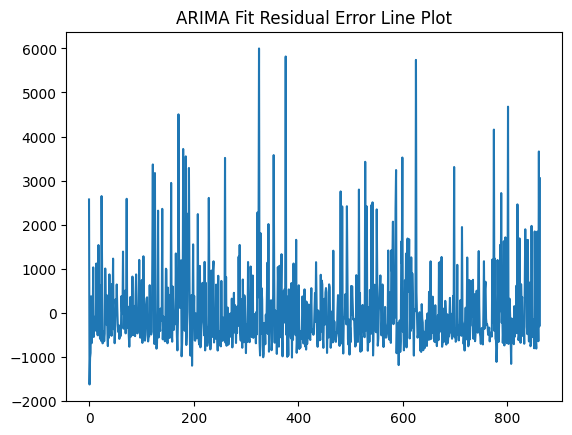

In [338]:
# lets create different graphs to better visualize the errors/differences between the targeted variable, and predicted variable
residuals = model_fit.resid # using our trained model to then find the residuals, aka the difference from predicted, to target variable

plt.plot(residuals)
plt.title('ARIMA Fit Residual Error Line Plot')
plt.show();

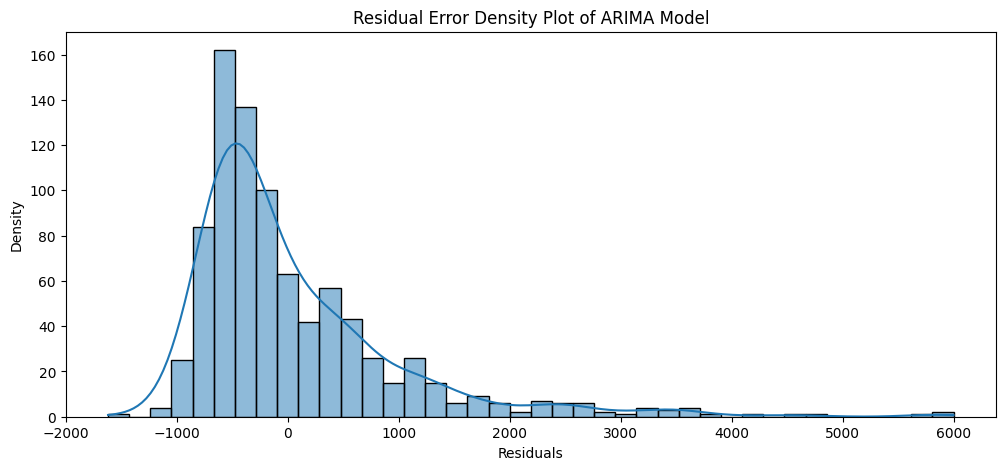

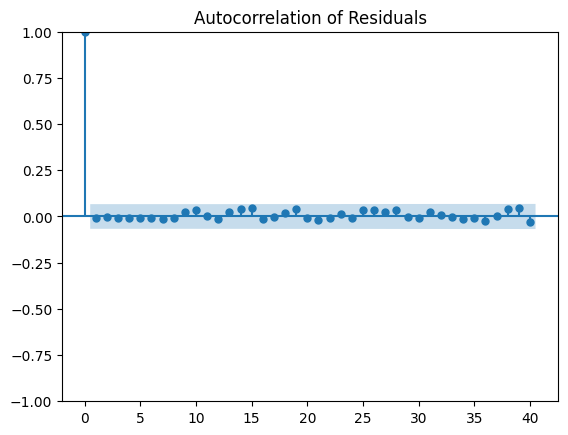

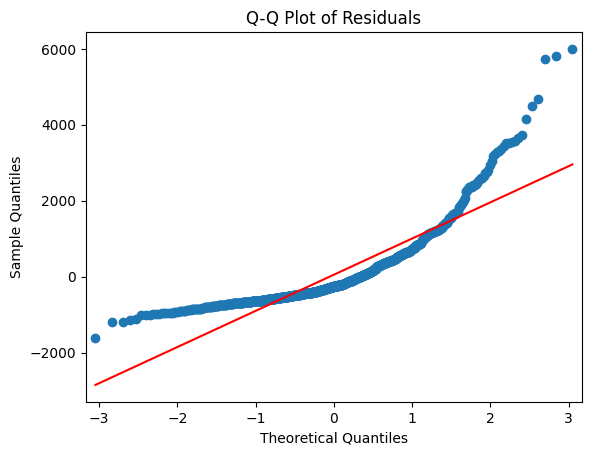

In [339]:
# Plot residual error density - Visualizes the distribution of residual errors
plt.figure(figsize=(12, 5))
sns.histplot(residuals, kde=True)
plt.title('Residual Error Density Plot of ARIMA Model')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Plot ACF of residuals to check for independence - Checking for autocorrelation, aka whether the model has fully captured the data's structure
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()

# Plot Q-Q plot to check for normality - Assessing normality of residuals, aka if the residuals follow a straight line, they'd be normally distributed
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

## Graph comments

#### Residual Error Density Plot:
Shows the distribution of residuals(difference between prediction, and actual), and the graph skews to the right. This suggests our model is underestimating the values of actual sales.

#### Autocorrelation of Residuals Plot:
Measures correlation between one time point of the model, compared to another time point, and the graph fall within the bounds of zero. This suggests that the model has captured all possible autocorrelation structures/patterns in the data.

#### Q-Q Residuals Plot:
Compares if points follow a straight 45 degree line, and the plot is displaying a convex deviation, with a heavy tail on the right end. The 'convex' might suggest that the distribution is more spread evenly in the central region. The 'heavy tail' means theres some presence of outliers.

In [340]:
# After visualizing the ARIMA model with are targeted values, lets see whats its forecasts are for the next 28 days of sales
# Before evaluating, I want to double check if we have missing dates on our forecasted month of 2017 December
target_forecast

,index,Order Date,Sales
0,863,2017-12-01,2542.2920
1,864,2017-12-02,3527.5040
2,865,2017-12-03,591.8400
3,866,2017-12-04,992.7820
4,867,2017-12-05,321.4800
5,868,2017-12-07,82.3800
6,869,2017-12-08,3368.2650
7,870,2017-12-09,1927.2330
8,871,2017-12-10,2102.2640
9,872,2017-12-11,1448.5290


In [341]:
# Turns out we do have missing dates, namely 6 of them. Let's arrange the missing month into the data
dec_2017 = pd.date_range(start='2017-12-01', end='2017-12-31', freq='D') # create dataset containing all the days of 2017 dec
target_forecast.set_index('Order Date', inplace=True) # set current forecast dates, as indexes

target_forecast = target_forecast.reindex(dec_2017) # reindexing the forecast dates, with dec_2017 dates
target_forecast.reset_index(inplace=True) # resetting index from dates to actual indexing, starting from 0

target_forecast['Sales'].fillna(0, inplace=True) # fill 'sales' with 0, if the new dates have null values

target_forecast

C:\Users\deanc\AppData\Local\Temp\ipykernel_50524\2149580650.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  target_forecast['Sales'].fillna(0, inplace=True) # fill 'sales' with 0, if the new dates have null values


,level_0,index,Sales
0,2017-12-01,863.0,2542.2920
1,2017-12-02,864.0,3527.5040
2,2017-12-03,865.0,591.8400
3,2017-12-04,866.0,992.7820
4,2017-12-05,867.0,321.4800
5,2017-12-06,NaN,0.0000
6,2017-12-07,868.0,82.3800
7,2017-12-08,869.0,3368.2650
8,2017-12-09,870.0,1927.2330
9,2017-12-10,871.0,2102.2640


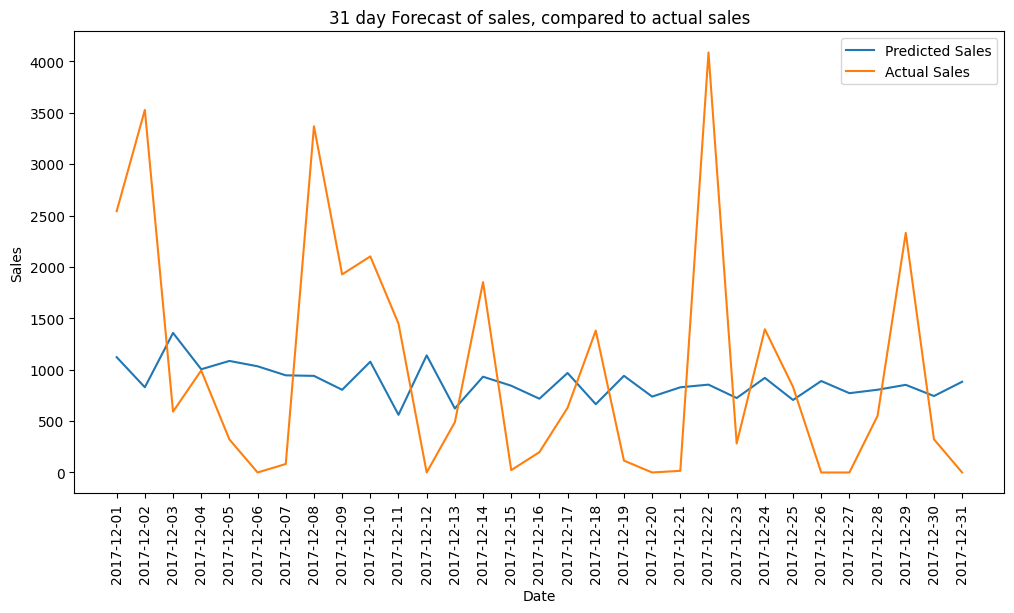

In [342]:
# With the target variable data sorted, lets create the forecasting from ARIMA
days = 31 # number of days we want the forecaster to generate
forecast_model = model_fit.get_forecast(steps=days)
forecast_df = forecast_model.summary_frame() # generates dataframe with different details in its variables for forecasting
forecast_df = forecast_df.reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

ax.set(title='31 day Forecast of sales, compared to actual sales',
       ylabel='Sales',
      xlabel='Date')

ax.plot(forecast_df['mean'], label='Predicted Sales')
ax.plot(target_forecast['level_0'].astype(str), target_forecast['Sales'], label='Actual Sales')
ax.legend()
ax.tick_params(axis='x', rotation=90)

### Seems like the ARIMA model follows the rough mean of values of the actual sales, which isn't the most helpful

In [343]:
# Let's see how well Ridge does in forecasting compared to ARIMA
forecast = forecast.copy()# prevent errors being raised for editing the dataframeon itself

forecast['Order_Year'] = forecast['Order Date'].dt.year # not the most efficient process. Would've done this process before splitting my data if I knew
# that regression models don't take date type data
forecast['Order_Month'] = forecast['Order Date'].dt.month
forecast['Order_Day'] = forecast['Order Date'].dt.day

forecast['Ship_Year'] = forecast['Ship Date'].dt.year
forecast['Ship_Month'] = forecast['Ship Date'].dt.month
forecast['Ship_Day'] = forecast['Ship Date'].dt.day

forecast_x = forecast.drop(['Sales', 'Order Date', 'Ship Date'], axis=1)
forecast_y = forecast['Sales']

model = Ridge()
model.fit(x_train, y_train)
forecast_ridge = model.predict(forecast_x)
forecast_ridge

array([1049.0179904 ,  144.94985084,  168.62598856,  458.63694081,
        260.45978266,  469.40314764,  165.84370465,  854.14208691,
        506.58748925,  527.83695546,  473.97408678,  450.91895268,
        844.96438318,  289.76940353,  196.74238774,  261.87525145,
         76.26950013,  441.38841913,  261.94710965,  269.84433384,
         36.23779593,  185.92266782,  928.96539473,  265.00428157,
        657.70808377,  236.67208251,  423.72088418,  226.23664684,
        147.15797777,  137.06859551,  522.17270817,  155.02333256,
        132.65712792,  353.01490781, 1200.57081095,  341.30179439,
        515.32879762,  167.73471848,  841.97784637,  375.0582614 ,
        268.97523261,  456.17408491,  141.07327252,  286.54175517,
        215.78824979,  483.28903341,  428.747245  ,  136.02219511,
        197.16238038,  196.55515723,   90.9745032 ,  124.41324712,
        738.03153114,  302.68536875,  367.70369606,  367.05627404,
        215.7823253 ,  304.10156869,  237.28123248,  180.19430

In [344]:
# Now lets plot this graph out against the December 2017 sales
forecast_y = forecast_y.reset_index() # resetting index so both target and forecast align

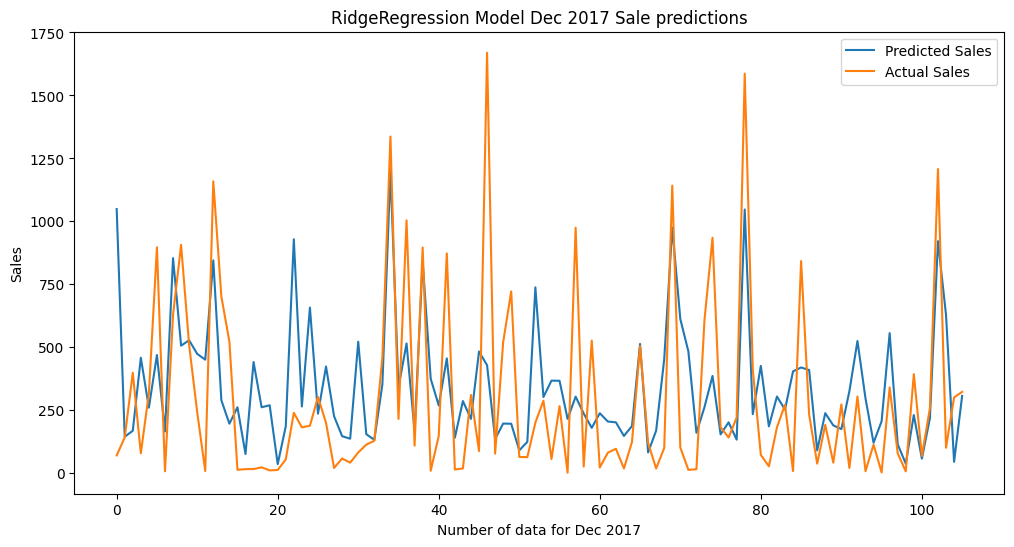

In [345]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast_ridge, label='Predicted Sales')
ax.plot(forecast_y['Sales'], label='Actual Sales')
ax.legend()
ax.set(title='RidgeRegression Model Dec 2017 Sale predictions',
      xlabel='Number of data for Dec 2017',
      ylabel='Sales');

# Graph comments
Plotting both Ridge predicition and actual sales, we can see it does an ok job with its prediction, and its resemblance is there

However there doesn't seem to be hard patterns as to why its not accurate. It appears to be random

Likely the innacuracy is caused just because of the lack of information, Ridge had to work from as most of the information were strings

If one-hot-encoded the other columns, especially the furniture item name, the accuracy is likely to be even higher

In [362]:
# Ridge does an ok job with sales prediction and the resemblance is there. Lets try a comparison by aggregating the data by a per-day-sale-sum basis
forecast_ridge = pd.DataFrame({'Sales': forecast_ridge}) # make forecast_ridge into a dataframe to add in date column
forecast_ridge['Order Date'] = forecast_y['Order Date'].values # copy the 'Order Date' column, only with its values
forecast_ridge

,Sales,Order Date
0,1049.017990,2017-12-01
1,144.949851,2017-12-01
2,168.625989,2017-12-01
3,458.636941,2017-12-01
4,260.459783,2017-12-01
...,...,...
101,218.576442,2017-12-29
102,921.318876,2017-12-29
103,628.561063,2017-12-29
104,45.334178,2017-12-29


In [373]:
forecast_ridge = forecast_ridge.groupby('Order Date')['Sales'].sum().reset_index() # sum sales up, by the grouping of the same date

forecast_ridge.set_index('Order Date', inplace=True) # set current forecast dates, as indexes

forecast_ridge = forecast_ridge.reindex(dec_2017) # reindexing the forecast dates, with dec_2017 dates
forecast_ridge.reset_index(inplace=True) # resetting index from dates to actual indexing, starting from 0

forecast_ridge['Sales'].fillna(0, inplace=True) # fill 'sales' with 0, if the new dates have null values

forecast_ridge

C:\Users\deanc\AppData\Local\Temp\ipykernel_50524\1803548591.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  forecast_ridge['Sales'].fillna(0, inplace=True) # fill 'sales' with 0, if the new dates have null values


,index,Sales
0,2017-12-01,3571.079492
1,2017-12-02,3094.051271
2,2017-12-03,1238.222668
3,2017-12-04,2580.354640
4,2017-12-05,934.184104
5,2017-12-06,0.000000
6,2017-12-07,522.172708
7,2017-12-08,2865.631490
8,2017-12-09,1942.185425
9,2017-12-10,1555.439556


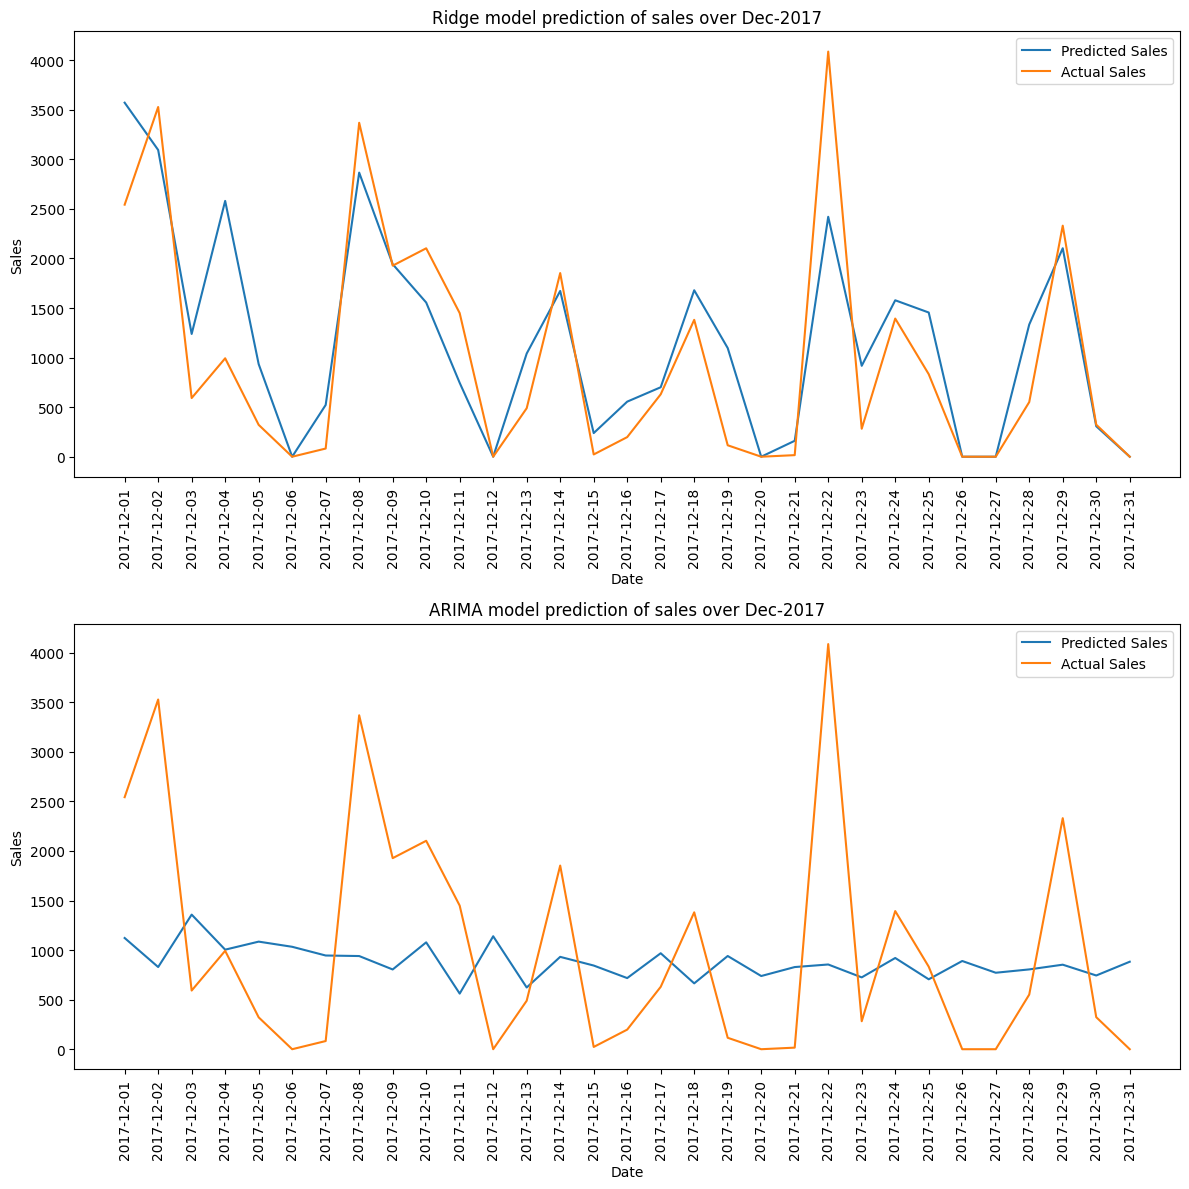

In [392]:
# Time to plot the ridge model and ARIMA model, to see the difference between the two
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 12))

ax1.set(title='Ridge model prediction of sales over Dec-2017',
       ylabel='Sales',
      xlabel='Date')

ax1.plot(forecast_ridge['Sales'], label='Predicted Sales')
ax1.plot(target_forecast['level_0'].astype(str), target_forecast['Sales'], label='Actual Sales')
ax1.legend()
ax1.tick_params(axis='x', rotation=90)


ax2.set(title='ARIMA model prediction of sales over Dec-2017',
       ylabel='Sales',
      xlabel='Date')

ax2.plot(forecast_df['mean'], label='Predicted Sales')
ax2.plot(target_forecast['level_0'].astype(str), target_forecast['Sales'], label='Actual Sales')
ax2.legend()
ax2.tick_params(axis='x', rotation=90)


plt.tight_layout() # This adjust the graph layout to prevent overlapping of graphs

In [401]:
# I assumed the ARIMA model roughly found the mean of the sales only, so I wondered whether the total of all sales is similar between ARIMA and target
arima_sum = forecast_df['mean'].sum()
target_sum = target_forecast['Sales'].sum()
print(f'ARIMA sum = {arima_sum}, Target sum = {target_sum}')

dif = 100*((target_sum - arima_sum)/target_sum)
print(f'The percentage difference from target sum is {dif}%')

ARIMA sum = 27304.41484592873, Target sum = 31407.466800000002
The percentage difference from target sum is 13.063937885214195%


### Despite ARIMA's inaccuracy, we can determine its overall sales is quite similar to the actual overall sales of dec-2017, therfore confirming my 'mean' theory

In [384]:
# The results displayed is definitely much better than what ARIMA has outputted
# Let's use the simple metrics of MAE, MSE, R2, and see the difference between Ridge and ARIMA
arima_r2 = r2_score(target_forecast['Sales'], forecast_df['mean'])
ridge_r2 = r2_score(target_forecast['Sales'], forecast_ridge['Sales'])

print(f'ARIMA R^2 score is {arima_r2}\nRidge R^2 score is {ridge_r2}')

ARIMA R^2 score is -0.023736089019580575
Ridge R^2 score is 0.7184704031094724


### R^2:
Represents the proportion of the variance from the predicted to the targeted variable. Ranges from 0 to 1, where higher values indicate a better fit

ARIMA has a negative value, meaning they're more likely to fit the opposite than what the targeted variable suggests

Ridge has a positive value of 0.78, indicating quite a good fit between the predicted and targeted variable

In [387]:
arima_mae = mean_absolute_error(target_forecast['Sales'], forecast_df['mean'])
ridge_mae = mean_absolute_error(target_forecast['Sales'], forecast_ridge['Sales'])

print(f'ARIMA MAE score is {arima_mae}\nRidge MAE score is {ridge_mae}')

ARIMA MAE score is 934.0774228816198
Ridge MAE score is 433.89524734895974


### Mean Absolute Error:
Measures the average absolute error magnitude from predictions. Basically the average absolute differences between prediction and targeted variable. The lower the number is, the more closer the prediction is to the targeted value

Results from ARIMA and Ridge, shows how Ridge can predict closer to the actual sales, compared to ARIMA

In [388]:
arima_mse = mean_squared_error(target_forecast['Sales'], forecast_df['mean'])
ridge_mse = mean_squared_error(target_forecast['Sales'], forecast_ridge['Sales'])

print(f'ARIMA MSE score is {arima_mse}\nRidge MSE score is {ridge_mse}')

ARIMA MSE score is 1366851.2690694553
Ridge MSE score is 375886.9995087863


### Mean Squared Error:
Similar to MAE, except it calculates its difference by squaring the difference between prediction and targeted values. It penalizes the larger errors more heavily, but is vice versa for smaller errors

Again, the results show Ridge being able to predict more closer to the actual sales, than ARIMA

## 5. Summary

## Steps to Train and Evaluate Models
`1. Data Preparation:` Cleaned and converting data, so they are properly formatted for the models that I'd be working with.

`2. Feature Engineering:` Converting date, to year, month, and day columns as data points the model could train with, since they can't train with date types

`3. Model Training:` Splitting data into train and test sets, to then fit and train the models

`4. Model Adjustments:` Making changes to the models by changing their parameters, or using scaling/normalizing of train datasets to see if results are better

`5. Model Visualization:` Forming graphs on the models, to better understand how accurate the model performed in fitting with the training/test data

`6. Model Forecasting:` Generate a 31-day forecast with ARIMA, and our previously best model, to see how well they could predict future sales

`7. Error/Bug Handling:` Addressed errors and fixing them, and handling misalignment of indexing from multiple different datasets

## Summary of Results from Training and Evaluating Models

### `1. Ridge Regression Model:`
`Low accuracy:` Comparing from Lasso, it was better in accuracy, but only by slightly with .2% increase in accuracy. Still quite low at 27.9%.

`Parameter Adjusting:` Made adjustments to the parameters of the model like Lasso. Though similar results were attained like Lasso, where the accuracy fell slightly below from the initial training.

`Prediction by per-day, rather than per-sale:` I was curious how the Ridge model, the best model I had would compare if instead of predicting indepedent sales, I were to sum up it's sales prediction by the date. Then comparing these new prediction results to the ARIMA model's prediction. I was quite surprised how you could see the resemblance to the actual day-by-day sales.


### `2. ARIMA Model:`
`Forecast Accuracy:` The model provided somewhat average forecasts of sales data. It captures the rough overall mean of the sales overtime, but is overall not helpful in finding out the potential forecast sales, if you're only ever looking at a rough straight line of where the mean distribution of all sales are.

`Residual Analysis:` There are quite a bit of skewing in the data, deviating from distributions that indicate the model being accurate with the sales data. The models found pretty much all the patterns/correlation it could, but there is too much variation in the sales for the model to train on. Q-Q plot also describes more potential outliers as well.


### `3. Key Findings:`
`ARIMA:` Was good at capturing the general trends of data, but struggled with the strong variations/fluctuations in values, exhibited by the residual error graphs.

`Ridge Regression:` Was ok at predicting the independent sales with the information it had, but once it was sum up by day-by-day, it's predictive accuracy went high from 27.9%, to 71.8%.


`My Thoughts:` I have some ideas why Ridge outperformed ARIMA. ARIMA only had one data column to work off of, which is 'Order Date'. While Ridge has many more, including the date column. Which had been adjusted to be able to work with the model. Ridge had much more data to work with, training on individual sales. Contrasting ARIMA, which trained by dates.

This may explain why ARIMA didn't do as well as Ridge. Furthermore, when we summed up all sales by the day, Ridge became more accurately, likely because the underestimation is balancing out with the overestimation. This was quite similar when summing ARIMA by the overall sales.

ARIMA might be more accurate with weekly or monthly sales, as the sales pattern become more apparent, and the outliers balance each other out from aggregation and summing.